# MIE 1517 Project Walkthrough: Student Attendance Tracking

Google Colab Link: https://colab.research.google.com/drive/18mkq9uEOG2LOlN6x94aP3DaAEz1nl961?usp=sharing

## TEAM 6 Members

|Name | Student ID | E-mail |
|--- | --- | --- |
|Ramy ElMallah|1009480303  | ramy.elmallah@mail.utoronto.ca |
|Athmha Krishnasamy |1008693424 | a.krishnasamy@mail.utoronto.ca|
|Keyan Ahmadi |1002436740 | k.ahmadi@mail.utoronto.ca|
|Bhagyashree Keswani |1006790849 | bhagyashree.keswani@mail.utoronto.ca|

## Motivation and Problem statement

- The problem that we choose to tackle is tracking classroom attendance. Being present in the classroom, allows students to both learn and grow with their peers.Attendance is an important part of daily classroom evaluation. It allows students to learn and grow alongside their peers, enabling different perspectives and ways of understanding various concepts (which self-study do not capture).

- Our goal here is to Manage classroom attendance in a more efficient manner. This could help better understand correlations between attendance and student performance.



- However, there’s 1 challenge that exists, which is that many of the datasets does not contain mask images. We aim to train our model to record students attendance who wear and do not wear masks. Thus, we mask half of the images in train, validation and test sets. For example: if an individual has 500 images in the dataset, 250 of them would be masked. The open source tool 'Mask The Face'(Reference: https://github.com/aqeelanwar/MaskTheFace) is used here. This tool simulates masks of different combination of color, pattern and mask type on faces to train deep NNs. 



## Datasets used

Knowing the problem in hand, we know many datasets exist that can be used for facial recognition. We use the following datasets for training and validation:

* Train and Test Datasets used: VGGFace2 ([link](https://academictorrents.com/details/535113b8395832f09121bc53ac85d7bc8ef6fa5b))
The dataset used for training is VGGFace2 that has more than a million train images of 9000+ subjects. The images have large variations in pose, age, illumination etc.

* Validation Dataset used: LabeledFacesInTheWild ([link](http://vis-www.cs.umass.edu/lfw/)),
LFW Dataset containing 13k images of 5000+ subjects.

* **Final model evaluation(demonstration) will be on unseen data from classroom where the models record presence/absence of a student**

## End-to-End pipeline

The following block diagram defines the end-to-end pipeline of preprocessing, training, validation and testing.

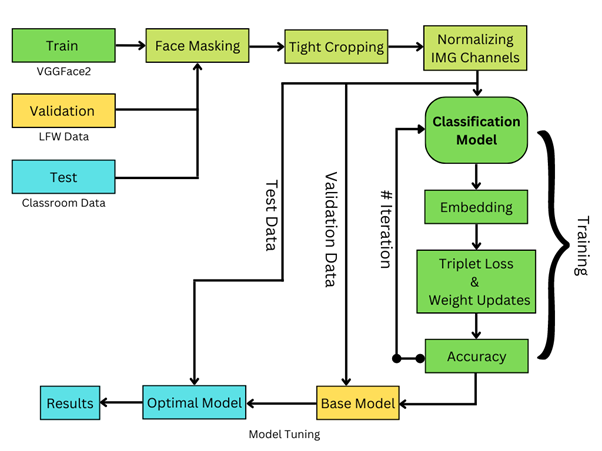


- First, for all 3 datasets(LFW, VGGFace2-Train, VGGFace2-Test), the images are first masked using an Open-source tool called "MaskTheFace". We considered different combination of color, pattern and mask type when generating the mask faces.  
 
- Next all the images are cropped and ready to be processed by the model.

- Multiple image pairs are provided to the network which then maps them to embedding vectors and calculates triplet loss. 

- The triplets consist of two image pairs of same(positive) and different(negative)persons. It separates the pair
of same identity (positive pair) from the pair of different identities (negative pair) by a distance margin calculated as Euclidean(L2) distance.

- The best model is then evaluated on the test data



## Importing Dependencies

### Imported Packages

In [ ]:
!pip install facenet_pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
# from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np 
import os
from torch.nn.modules.distance import PairwiseDistance
from torch.nn import TripletMarginLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torch.utils.data import TensorDataset, Dataset
import math
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

### Imported Code

**This code below is used to calculate the mean and std deviation of each color pixel over the whole dataset and is used to normalize data fed to the model. If each input parameter has a simialr distribution, it will help the model converge faster.**

In [ ]:
"""
  Code copied from https://github.com/tamerthamoqa/facenet-pytorch-glint360k
"""

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

def calculate_vggface2_rgb_mean_std(dir, batch_size):
    """Calculates the mean and standard deviation of the RGB channels of all images in the dataset with
       cropped faces by the MTCNN Face Detection model (or any other dataset dataset) when transformed into a Torch
       Tensor of range [0.0, 1.0].
       Method taken from this youtube video by Aladdin Persson: https://www.youtube.com/watch?v=y6IEcEBRZks
    """

    dataset = datasets.ImageFolder(dir, transforms.ToTensor())
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(dataloader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = ((channels_squared_sum / num_batches) - mean ** 2) ** 0.5

    print("Mean: {}, Std: {}".format(mean, std))
    return mean, std

**The code below is a wrapper for the torch Dataset to create triplets from the faces data in the directory provided. The function takes a CSV file that contains paths of all the images inside the directory that you want to use. It generates triplets online by creating hard positive and negative samples from within a mini-batch. The triplet loss function is used to calculate the loss such that an 'anchor image' of a specific person is closer to all other 'positive images' of the same person than it is to 'negative images' of any other person.** 

In [ ]:
"""
Code copied from https://github.com/tamerthamoqa/facenet-pytorch-glint360k
The original code was imported from tbmoon's 'facenet' repository:
    https://github.com/tbmoon/facenet/blob/master/data_loader.py
    The code was modified to speed up the triplet generation process by bypassing the dataframe.loc operation,
     generate batches according to a set amount of human identities (classes) per triplet batch, and to
     support .png, .jpg, and .jpeg files.
"""


import os
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset


class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, training_dataset_csv_path, num_triplets, epoch, num_human_identities_per_batch=32,
                 triplet_batch_size=544, training_triplets_path=None, transform=None):
        """
        Args:
        root_dir: Absolute path to dataset.
        training_dataset_csv_path: Path to csv file containing the image paths inside the training dataset folder.
        num_triplets: Number of triplets required to be generated.
        epoch: Current epoch number (used for saving the generated triplet list for this epoch).
        num_generate_triplets_processes: Number of separate Python processes to be created for the triplet generation
                                          process. A value of 0 would generate a number of processes equal to the
                                          number of available CPU cores.
        num_human_identities_per_batch: Number of set human identities per batch size.
        triplet_batch_size: Required number of triplets in a batch.
        training_triplets_path: Path to a pre-generated triplet numpy file to skip the triplet generation process (Only
                                 will be used for one epoch).
        transform: Required image transformation (augmentation) settings.
        """

        # Modified here to set the data types of the dataframe columns to be suitable for other datasets other than the
        #  VggFace2 dataset (Casia-WebFace in this case because of the identities starting with numbers automatically
        #  forcing the 'name' column as being of type 'int' instead of type 'object')
        self.df = pd.read_csv(training_dataset_csv_path, dtype={'id': object, 'name': object, 'class': int})
        self.root_dir = root_dir
        self.num_triplets = num_triplets
        self.num_human_identities_per_batch = num_human_identities_per_batch
        self.triplet_batch_size = triplet_batch_size
        self.epoch = epoch
        self.transform = transform

        # Modified here to bypass having to use pandas.dataframe.loc for retrieving the class name
        #  and using dataframe.iloc for creating the face_classes dictionary
        df_dict = self.df.to_dict()
        self.df_dict_class_name = df_dict["name"]
        self.df_dict_id = df_dict["id"]
        self.df_dict_class_reversed = {value: key for (key, value) in df_dict["class"].items()}

        if training_triplets_path is None:
            self.training_triplets = self.generate_triplets()
        else:
            print("Loading pre-generated triplets file ...")
            self.training_triplets = np.load(training_triplets_path)

    def make_dictionary_for_face_class(self):
        """
            face_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
        """
        face_classes = dict()
        for idx, label in enumerate(self.df['class']):
            if label not in face_classes:
                face_classes[label] = []
            # Instead of utilizing the computationally intensive pandas.dataframe.iloc() operation
            face_classes[label].append(self.df_dict_id[idx])

        return face_classes

    def generate_triplets(self):
        triplets = []
        classes = self.df['class'].unique()
        face_classes = self.make_dictionary_for_face_class()

        print("\nGenerating {} triplets ...".format(self.num_triplets))
        num_training_iterations_per_process = self.num_triplets / self.triplet_batch_size
        progress_bar = tqdm(range(int(num_training_iterations_per_process)))  # tqdm progress bar does not iterate through float numbers

        for training_iteration in progress_bar:

            """
            For each batch: 
                - Randomly choose set amount of human identities (classes) for each batch
            
                  - For triplet in batch:
                      - Randomly choose anchor, positive and negative images for triplet loss
                      - Anchor and positive images in pos_class
                      - Negative image in neg_class
                      - At least, two images needed for anchor and positive images in pos_class
                      - Negative image should have different class as anchor and positive images by definition
            """
            classes_per_batch = np.random.choice(classes, size=self.num_human_identities_per_batch, replace=False)

            for triplet in range(self.triplet_batch_size):

                pos_class = np.random.choice(classes_per_batch)
                neg_class = np.random.choice(classes_per_batch)

                while len(face_classes[pos_class]) < 2:
                    pos_class = np.random.choice(classes_per_batch)

                while pos_class == neg_class:
                    neg_class = np.random.choice(classes_per_batch)

                # Instead of utilizing the computationally intensive pandas.dataframe.loc() operation
                pos_name_index = self.df_dict_class_reversed[pos_class]
                pos_name = self.df_dict_class_name[pos_name_index]

                neg_name_index = self.df_dict_class_reversed[neg_class]
                neg_name = self.df_dict_class_name[neg_name_index]

                if len(face_classes[pos_class]) == 2:
                    ianc, ipos = np.random.choice(2, size=2, replace=False)

                else:
                    ianc = np.random.randint(0, len(face_classes[pos_class]))
                    ipos = np.random.randint(0, len(face_classes[pos_class]))

                    while ianc == ipos:
                        ipos = np.random.randint(0, len(face_classes[pos_class]))

                ineg = np.random.randint(0, len(face_classes[neg_class]))

                triplets.append(
                    [
                        face_classes[pos_class][ianc],
                        face_classes[pos_class][ipos],
                        face_classes[neg_class][ineg],
                        pos_class,
                        neg_class,
                        pos_name,
                        neg_name
                    ]
                )

        print("Saving training triplets list in 'datasets/generated_triplets' directory ...")
        np.save('datasets/generated_triplets/epoch_{}_training_triplets_{}_identities_{}_batch_{}.npy'.format(
                self.epoch, self.num_triplets, self.num_human_identities_per_batch, self.triplet_batch_size
            ),
            triplets
        )
        print("Training triplets' list Saved!\n")

        return triplets

    # Added this method to allow .jpg, .png, and .jpeg image support
    def add_extension(self, path):
        if os.path.exists(path + '.jpg'):
            return path + '.jpg'
        elif os.path.exists(path + '.png'):
            return path + '.png'
        elif os.path.exists(path + '.jpeg'):
            return path + '.jpeg'
        else:
            raise RuntimeError('No file "{}" with extension .png or .jpg or .jpeg'.format(path))

    def __getitem__(self, idx):

        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]

        anc_img = self.add_extension(os.path.join(self.root_dir, str(pos_name), str(anc_id)))
        pos_img = self.add_extension(os.path.join(self.root_dir, str(pos_name), str(pos_id)))
        neg_img = self.add_extension(os.path.join(self.root_dir, str(neg_name), str(neg_id)))

        # Modified to open as PIL image in the first place
        anc_img = Image.open(anc_img)
        pos_img = Image.open(pos_img)
        neg_img = Image.open(neg_img)

        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))

        sample = {
            'anc_img': anc_img,
            'pos_img': pos_img,
            'neg_img': neg_img,
            'pos_class': pos_class,
            'neg_class': neg_class
        }

        if self.transform:
            sample['anc_img'] = self.transform(sample['anc_img'])
            sample['pos_img'] = self.transform(sample['pos_img'])
            sample['neg_img'] = self.transform(sample['neg_img'])

        return sample

    def __len__(self):
        return len(self.training_triplets)


"""This code was imported from tbmoon's 'facenet' repository:
    https://github.com/tbmoon/facenet/blob/master/utils.py
"""

import torch
from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance
class TripletLoss(Function):

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(p=2)

    def forward(self, anchor, positive, negative):
        pos_dist = self.pdist.forward(anchor, positive)
        neg_dist = self.pdist.forward(anchor, negative)

        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min=0.0)
        loss = torch.mean(hinge_dist)

        return loss


In [ ]:
import glob
import time

def generate_csv_file(dataroot, csv_name="generated_csv.csv"):
    """Generates a csv file containing the image paths of the dataset for use in triplet selection in
    triplet loss training.
    Args:
        dataroot (str): absolute path to the training dataset.
        csv_name (str): name of the resulting csv file.
    """
    print("\nLoading image paths ...")
    files = glob.glob(dataroot + "/*/*")

    start_time = time.time()
    list_rows = []

    print("Number of files: {}".format(len(files)))
    print("\nGenerating csv file ...")

    progress_bar = enumerate(tqdm(files))

    for file_index, file in progress_bar:

        face_id = os.path.basename(file).split('.')[0]
        face_label = os.path.basename(os.path.dirname(file))

        # Better alternative than dataframe.append()
        row = {'id': face_id, 'name': face_label}
        list_rows.append(row)

    dataframe = pd.DataFrame(list_rows)
    dataframe = dataframe.sort_values(by=['name', 'id']).reset_index(drop=True)

    # Encode names as categorical classes
    dataframe['class'] = pd.factorize(dataframe['name'])[0]
    dataframe.to_csv(path_or_buf=csv_name, index=False)

    elapsed_time = time.time()-start_time
    print("\nDone! Elapsed time: {:.2f} minutes.".format(elapsed_time/60))


**The below code is used for processing lfw images along with their labels lfw_pairs.txt.**

In [ ]:
import torchvision.datasets as datasets
import os
import numpy as np


class LFWDataset(datasets.ImageFolder):
    def __init__(self, dir, pairs_path, transform=None):

        super(LFWDataset, self).__init__(dir, transform)

        self.pairs_path = pairs_path

        # LFW dir contains 2 folders: faces and lists
        self.validation_images = self.get_lfw_paths(dir)

    def read_lfw_pairs(self, pairs_filename):
        pairs = []
        with open(pairs_filename, 'r') as f:
            for line in f.readlines()[1:]:
                pair = line.strip().split()
                pairs.append(pair)

        return np.array(pairs, dtype=object)

    def get_lfw_paths(self, lfw_dir):
        pairs = self.read_lfw_pairs(self.pairs_path)

        nrof_skipped_pairs = 0
        path_list = []
        issame_list = []
        for pair in pairs:
            if len(pair) == 3:
                path0 = self.add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
                path1 = self.add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])))
                issame = True
            elif len(pair) == 4:
                path0 = self.add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
                path1 = self.add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
                issame = False
            if os.path.exists(path0) and os.path.exists(path1):  # Only add the pair if both paths exist
                path_list.append((path0, path1, issame))
                issame_list.append(issame)
            else:
                nrof_skipped_pairs += 1
        if nrof_skipped_pairs > 0:
            print('Skipped %d image pairs' % nrof_skipped_pairs)

        return path_list
    
    # Modified here
    def add_extension(self, path):
        # we don't actually add extension but instead we will look for the full filename the starts with this query
        if os.path.exists(os.path.dirname(path)):
          for existing_file_path in os.listdir(os.path.dirname(path)):
            #print(existing_file_path)
            existing_file_path = os.path.join(os.path.dirname(path), existing_file_path)
            if os.path.basename(existing_file_path).startswith(os.path.basename(path)):
              return existing_file_path
            #else:
              #print(os.path.basename(existing_file_path), os.path.basename(path))
        return ""
    
    def __getitem__(self, index):
        """
        Args:
            index: Index of the triplet or the matches - not of a single image
        Returns:
        """

        def transform(img_path):
            """Convert image into numpy array and apply transformation
               Doing this so that it is consistent with all other datasets
               to return a PIL Image.
            """

            img = self.loader(img_path)
            return self.transform(img)

        (path_1, path_2, issame) = self.validation_images[index]
        img1, img2 = transform(path_1), transform(path_2)
        return img1, img2, issame

    def __len__(self):
        return len(self.validation_images)


## Preprocessing the dataset images

### Masking the images

**In this part, as described earlier, a subset of images from train, validation and test sets are masked.**

In [ ]:
# Change Directory to the location where all the required mask_the_face files are downloaded
%cd /Users/keyanahmadi/Desktop/Final_Project/MaskTheFace

/Users/keyanahmadi/Desktop/Final_Project/MaskTheFace


In [ ]:
### Masking the Images

# Defining the Directory of the images to be masked
dir_1 = '/Users/keyanahmadi/Desktop/Final_Project/Train_sub_sub'

# Defining the Directory of the different patterns for the masks
#pattern_dir = '/content/drive/MyDrive/MaskTheFace/masks/textures/check'
pattern_dir = "/Users/keyanahmadi/Desktop/Final_Project/MaskTheFace/masks/textures/check"

# Making a list of the different mask options that exist 
mask_options = ["surgical", "N95", "KN95", "cloth"]

# Making a list of the different mask pattern options that exist 
pattern_options = ["check_1.png","check_2.jpg","check_3.png","check_4.jpg","check_5.jpg",\
                   "cherry.jpg","lemon.png","strawberry.png","pineapple.png", "bananas.png",\
                   "floral_1.png", "floral_2.jpg", "floral_3.jpg", "floral_4.jpg", "floral_5.jpg"]

folder_count = 0
# Looping through Each sub-folder of the Train Dataset
for folder in os.listdir(dir_1):
  if os.path.isdir(dir_1 + '/' + folder): # Perform the following if the path corresponds to a folder
      
      # Printing the folder count and folder name for tracking purposes
      print("-------------------------------------------------------")
      print("Folder Count:", folder_count+1, "| Folder Name:", folder)
      print("-------------------------------------------------------")
    
      # Looping through each image of the sub-folders
      for i, filename in enumerate(os.listdir(dir_1 + '/' + folder)):

          # Performing masking only on half of the images of each folder
          if i % 2 == 0:

            # Generating Random Hex Colors 
            r = lambda: random.randint(0,255)
            Color_Options = '#%02X%02X%02X' % (r(),r(),r())

            # Finding each image path directory
            f = os.path.join(dir_1 + '/' + folder, filename)
            # Applying the "mask the face" algorithm to the images
            %run mask_the_face.py --path {f} \
                                     --mask_type {random.choice(mask_options)} \
                                     --pattern {pattern_dir + "/" + random.choice(pattern_options)} \
                                     --pattern_weight {random.uniform(0.5, 1.0)} \
                                     --color "{Color_Options}" \
                                     --color_weight {random.uniform(0.5, 1.0)} \
                                     --verbose \

            ### The "mask the face" algorithm arguments explained:            

            #                       --path                      Path of the image to be masked
            #                       --mask_type :               Selecting the mask type
            #                       --pattern :                 Selecting the mask pattern
            #                       --pattern_weight :          selecting the pattern intensity of the mask
            #                       --color :                   selecting the color of the mask
            #                       --color_weight :            Selecting the color intensity of the mask
            #                       --verbose :                 Shows important messages when masking images
            #                       --write_original_image :    Keeps the original image (unmasked) saved
            #                       &>/dev/null &               Hiding printed messages during training


            ### Important Note: 
            ### All "mask types", "patterns", "pattern weight", "color", and "color weight" were selected randomly 
            ### The original images of the mask images will be disregarded from the training dataset

      folder_count +=1

In [ ]:
### The following sections are strictly for illustration purposes; we will be plotting the images before and after applying the "mask the face" algorithm

# Below we are finding a subset of the images before and after applying the "mask the face" algorithm

Paths_No_Mask = []
Paths_With_Mask = []

dir_sub_folder = '/Users/keyanahmadi/Desktop/Final_Project/Train_sub_sub/n000002'

for i, filename in enumerate(os.listdir(dir_sub_folder)):
    f = os.path.join(dir_sub_folder, filename)

    if any(mask in f for mask in mask_options):
      Paths_With_Mask.append(f)
    else:
      Paths_No_Mask.append(f)

    if i > 30:
      break

Paths_No_Mask.sort() 
Paths_With_Mask.sort()

### Brief visualization of the dataset

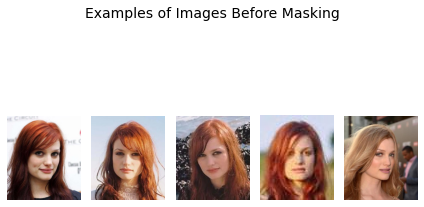

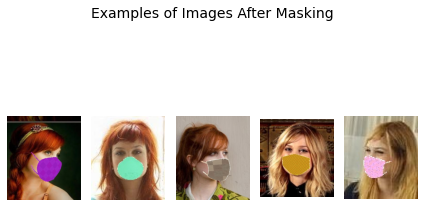

In [ ]:
# Plotting 5 examples of images before and after applying the "mask the face" algorithm

k=0
for p in Paths_No_Mask:

  plt.subplot(1, 5, k+1)
  plt.suptitle("Examples of Images Before Masking", fontsize=14)
  plt.axis("off")
  img_color = cv2.imread(p,-1)
  plt.tight_layout()
  plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
  
  k += 1
  if k > 4:
      break
  
plt.show()
print("")

k=0
for p in Paths_With_Mask:

  plt.subplot(1, 5, k+1)
  plt.suptitle("Examples of Images After Masking", fontsize=14)
  plt.axis("off")
  img_color = cv2.imread(p,-1)
  plt.tight_layout()
  plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
  
  k += 1
  if k > 4:
      break

**The above figure shows sample masked images with masks of different colour, texture etc.**

### Cropping all the images in train set (both masked and unmasked)

#### Cropping first subset of 418245 images in train set:

In [ ]:
mtcnn = MTCNN(image_size=160, margin=0)
data_dir = 'C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\train_subset_masked'
dataset = datasets.ImageFolder(data_dir)
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples]
        
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=1,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
del mtcnn
!cp -r C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\train_mask_cropped

Batch 418245 of 418245

'cp' is not recognized as an internal or external command,
operable program or batch file.


#### Cropping second subset of 413913 images in train set:

In [ ]:
mtcnn = MTCNN(image_size=160, margin=0)
data_dir = 'C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\train_subset_masked2'
dataset = datasets.ImageFolder(data_dir)
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples]
        
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=1,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
del mtcnn
!cp -r C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\train_subset_masked2_cropped

Batch 413913 of 413913

'cp' is not recognized as an internal or external command,
operable program or batch file.


### Cropping 13233 images in validation set (LFW)

In [ ]:
mtcnn = MTCNN(image_size=160, margin=0)
data_dir="C:\\Users\\bhagyashreekeswani\\Desktop\\lfw_masked"
dataset = datasets.ImageFolder(data_dir)
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples]
        
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=1,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
del mtcnn
!cp -r C:\\Users\\bhagyashreekeswani\\Desktop\\lfw_masked_cropped

Batch 13233 of 13233

'cp' is not recognized as an internal or external command,
operable program or batch file.


### Cropping 169396 images in test set (VGG)

In [ ]:
mtcnn = MTCNN(image_size=160, margin=0)
data_dir="C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\test_masked"
dataset = datasets.ImageFolder(data_dir)
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples]
        
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=1,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
del mtcnn
!cp -r C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\test_masked_cropped

Batch 169396 of 169396

'cp' is not recognized as an internal or external command,
operable program or batch file.


### Calculating Mean and Standard Deviation of train images
 
The code below calculates the mean and std deviation for each channel of images in the train dataset to use them for normalization

In [ ]:
data_dir = 'C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\train_subset_masked'
dataset_mean, dataset_std = calculate_vggface2_rgb_mean_std(data_dir+'_cropped', 2048)

100%|██████████| 392/392 [16:19<00:00,  2.50s/it]


Mean: tensor([0.6025, 0.4704, 0.4078]), Std: tensor([0.2493, 0.2278, 0.2257])


### Loading the validation data

**The below code is used to normalize and transform the data for validation.**

In [ ]:
def load_data_for_evaluation(image_size, batch_size, num_workers):
    data_transforms = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.6025, 0.4704, 0.4078], 
        std=[0.2493, 0.2278, 0.2257]
    )
    ])

    dataloader = torch.utils.data.DataLoader(
    dataset=LFWDataset(
        dir='C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\lfw_masked_cropped',
        pairs_path='C:\\Users\\bhagyashreekeswani\\Desktop\\DL_Project\\lfw_pairs.txt',
        transform=data_transforms
    ),
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
    )
    
    return dataloader
    